# Programming Assignment: Sunspots 

```
ProtonX - TensorFlow Class 
```

Time Series: Sunspot

### Hướng dẫn làm bài  

Một số yêu cầu:
- Sử dụng TensorFlow.

Tiêu chí chấm điểm: 
- Yêu cầu MAE < 0.12




### Thực hiện 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-12-22 14:06:54--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.73.208, 142.250.31.128, 172.217.7.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.73.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-12-22 14:06:54 (107 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



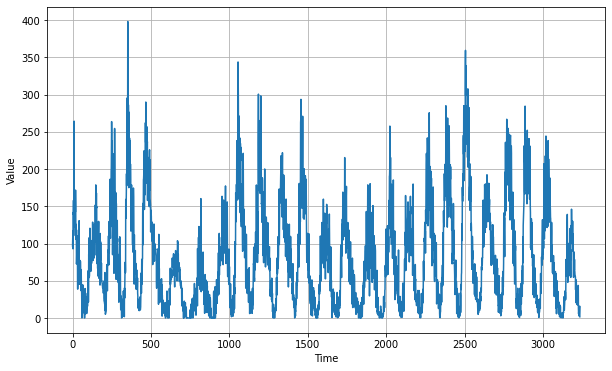

In [3]:
import csv
time_step = []
temps = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  #step=0
  for row in reader:
    temps.append(float(row[2]))
    time_step.append(int(row[0]))
    #step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [4]:
from sklearn.preprocessing import minmax_scale

In [5]:
scaled_series = minmax_scale(series)
scaled_series

array([0.24284279, 0.26192868, 0.29306881, ..., 0.03314917, 0.03992968,
       0.00401808])

In [ ]:
split_time = 3000
time_train = time[:split_time]
x_train = scaled_series[:split_time]
time_valid = time[split_time:]
x_valid = scaled_series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Conv1D
from tensorflow.keras.models import Sequential

In [ ]:
x_train

array([0.24284279, 0.26192868, 0.29306881, ..., 0.19713712, 0.24434957,
       0.29934706])

In [ ]:
tf.random.set_seed(0)
np.random.seed(0)

train_dataset = windowed_dataset(x_train, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

model = Sequential([
                    Conv1D(filters=60, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
                    LSTM(64, return_sequences=True),
                    LSTM(64, return_sequences=True),
                    Dense(30, activation='relu'),
                    Dense(16, activation='relu'),
                    Dense(1)
])

model.compile(loss=tf.losses.Huber(), optimizer='adam', metrics=['mae'])

model.fit(train_dataset, epochs=100)

Epoch 1/100
93/93 [==============================] - 1s 12ms/step - loss: 0.0060 - mae: 0.0764
Epoch 2/100
93/93 [==============================] - 1s 11ms/step - loss: 0.0026 - mae: 0.0515
Epoch 3/100
93/93 [==============================] - 1s 11ms/step - loss: 0.0022 - mae: 0.0482
Epoch 4/100
93/93 [==============================] - 1s 11ms/step - loss: 0.0021 - mae: 0.0467
Epoch 5/100
93/93 [==============================] - 1s 11ms/step - loss: 0.0020 - mae: 0.0456
Epoch 6/100
93/93 [==============================] - 1s 11ms/step - loss: 0.0020 - mae: 0.0454
Epoch 7/100
93/93 [==============================] - 1s 11ms/step - loss: 0.0020 - mae: 0.0450
Epoch 8/100
93/93 [==============================] - 1s 11ms/step - loss: 0.0020 - mae: 0.0452
Epoch 9/100
93/93 [==============================] - 1s 11ms/step - loss: 0.0020 - mae: 0.0452
Epoch 10/100
93/93 [==============================] - 1s 11ms/step - loss: 0.0020 - mae: 0.0452
Epoch 11/100
93/93 [=============================

In [ ]:
rnn_forecast = model_forecast(model, scaled_series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

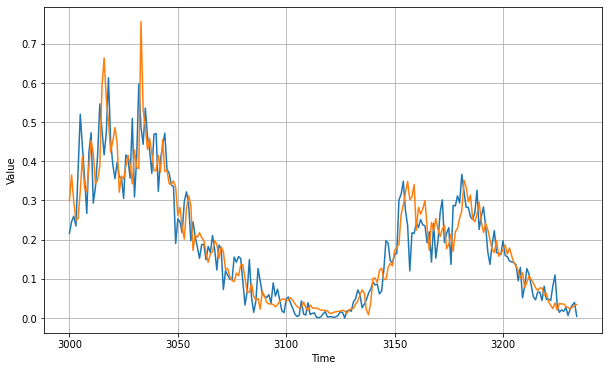

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)